### Load your libraries

In [1]:
# Common Python Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import math
import datetime as dt
import os
import logging

In [2]:
# Azure Libaries
from azureml.core import Datastore
from azureml.core.dataset import Dataset
from azureml.core.workspace import Workspace
from azureml.core.authentication import InteractiveLoginAuthentication
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.experiment import Experiment
from azureml.core.environment import Environment
from azureml.core.conda_dependencies import CondaDependencies
from azureml.explain.model._internal.explanation_client import ExplanationClient
from azureml.train.hyperdrive import HyperDriveConfig, PrimaryMetricGoal, BayesianParameterSampling, uniform, choice
from azureml.core import Run
from azureml.train.estimator import Estimator
from azureml.widgets import RunDetails

In [3]:
# XGBoost & sklearn Libraries
from numpy import loadtxt
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer, r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV   #Perforing grid search
from sklearn import metrics
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import xgboost 
from sklearn import preprocessing
import matplotlib.pylab as plt
from matplotlib import pyplot
from collections import Counter

### Set your Workspace

In [4]:
# Check the base version of AzureMl
import azureml.core
print("You are currently using version " + azureml.core.VERSION + " of the Azure ML SDK")

You are currently using version 1.6.0 of the Azure ML SDK


In [5]:
# Retrieve your workspace
ws = Workspace.from_config()

### Set your Datasets

In [6]:
# Retrieve your Datasets by name
df_name  = "auto-mpg-classification-input" # CHANGE HERE


# Load Data in as Tabular Datasets
df_tab  = Dataset.get_by_name(ws, df_name, version='latest')


# Change to pandas dataframe
df = df_tab.to_pandas_dataframe()

In [7]:
df.head()

Column1  Column2  Column3 Column4  Column5  Column6  Column7  Column8  \
0     18.0        8    307.0     130     3504     12.0       70        1   
1     15.0        8    350.0     165     3693     11.5       70        1   
2     18.0        8    318.0     150     3436     11.0       70        1   
3     16.0        8    304.0     150     3433     12.0       70        1   
4     17.0        8    302.0     140     3449     10.5       70        1   

                         Column9  
0  \t"chevrolet chevelle malibu"  
1          \t"buick skylark 320"  
2         \t"plymouth satellite"  
3              \t"amc rebel sst"  
4                \t"ford torino"

In [8]:
# get rid of the last column as we dont gain any info from it
df_column9_dropped = df.drop(['Column9'], axis=1)
df_column9_dropped.head()

Column1  Column2  Column3 Column4  Column5  Column6  Column7  Column8
0     18.0        8    307.0     130     3504     12.0       70        1
1     15.0        8    350.0     165     3693     11.5       70        1
2     18.0        8    318.0     150     3436     11.0       70        1
3     16.0        8    304.0     150     3433     12.0       70        1
4     17.0        8    302.0     140     3449     10.5       70        1

In [9]:
# add header row to the dataframe
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight','Acceleration', 'Model Year', 'Origin']
df_column9_dropped.columns = column_names
df_with_headers = df_column9_dropped
df_with_headers.head()

MPG  Cylinders  Displacement Horsepower  Weight  Acceleration  Model Year  \
0  18.0          8         307.0        130    3504          12.0          70   
1  15.0          8         350.0        165    3693          11.5          70   
2  18.0          8         318.0        150    3436          11.0          70   
3  16.0          8         304.0        150    3433          12.0          70   
4  17.0          8         302.0        140    3449          10.5          70   

   Origin  
0       1  
1       1  
2       1  
3       1  
4       1

In [10]:
df_with_headers["Horsepower"].unique()   

array(['130', '165', '150', '140', '198', '220', '215', '225', '190',
       '170', '160', '95', '97', '85', '88', '46', '87', '90', '113',
       '200', '210', '193', '?', '100', '105', '175', '153', '180', '110',
       '72', '86', '70', '76', '65', '69', '60', '80', '54', '208', '155',
       '112', '92', '145', '137', '158', '167', '94', '107', '230', '49',
       '75', '91', '122', '67', '83', '78', '52', '61', '93', '148',
       '129', '96', '71', '98', '115', '53', '81', '79', '120', '152',
       '102', '108', '68', '58', '149', '89', '63', '48', '66', '139',
       '103', '125', '133', '138', '135', '142', '77', '62', '132', '84',
       '64', '74', '116', '82'], dtype=object)

In [11]:
# remove rows with '?' character

df_with_headers = df_with_headers[df_with_headers.Horsepower != '?']
df_with_headers.head()

MPG  Cylinders  Displacement Horsepower  Weight  Acceleration  Model Year  \
0  18.0          8         307.0        130    3504          12.0          70   
1  15.0          8         350.0        165    3693          11.5          70   
2  18.0          8         318.0        150    3436          11.0          70   
3  16.0          8         304.0        150    3433          12.0          70   
4  17.0          8         302.0        140    3449          10.5          70   

   Origin  
0       1  
1       1  
2       1  
3       1  
4       1

### Prepare Modeling Data


### The "Origin" column is really categorical, not numeric. So convert that to a one-hot:



In [12]:
df_with_headers['Origin'] = df_with_headers['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})

df_with_headers.head()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


MPG  Cylinders  Displacement Horsepower  Weight  Acceleration  Model Year  \
0  18.0          8         307.0        130    3504          12.0          70   
1  15.0          8         350.0        165    3693          11.5          70   
2  18.0          8         318.0        150    3436          11.0          70   
3  16.0          8         304.0        150    3433          12.0          70   
4  17.0          8         302.0        140    3449          10.5          70   

  Origin  
0    USA  
1    USA  
2    USA  
3    USA  
4    USA

In [13]:
# generate binary values using get_dummies

# you can use pandas get_dummies to convert categorical variable into dummy/indicator variables.
# or use sklean OneHotEncoder
encoded_df = pd.get_dummies(df_with_headers, columns=["Origin"], prefix=["Origin_is"] )

encoded_df.head()

MPG  Cylinders  Displacement Horsepower  Weight  Acceleration  Model Year  \
0  18.0          8         307.0        130    3504          12.0          70   
1  15.0          8         350.0        165    3693          11.5          70   
2  18.0          8         318.0        150    3436          11.0          70   
3  16.0          8         304.0        150    3433          12.0          70   
4  17.0          8         302.0        140    3449          10.5          70   

   Origin_is_Europe  Origin_is_Japan  Origin_is_USA  
0                 0                0              1  
1                 0                0              1  
2                 0                0              1  
3                 0                0              1  
4                 0                0              1

### Split the data into train and test

In [14]:
train_dataset = encoded_df.sample(frac=0.8,random_state=0)
test_dataset = encoded_df.drop(train_dataset.index)

### Inspect the data 


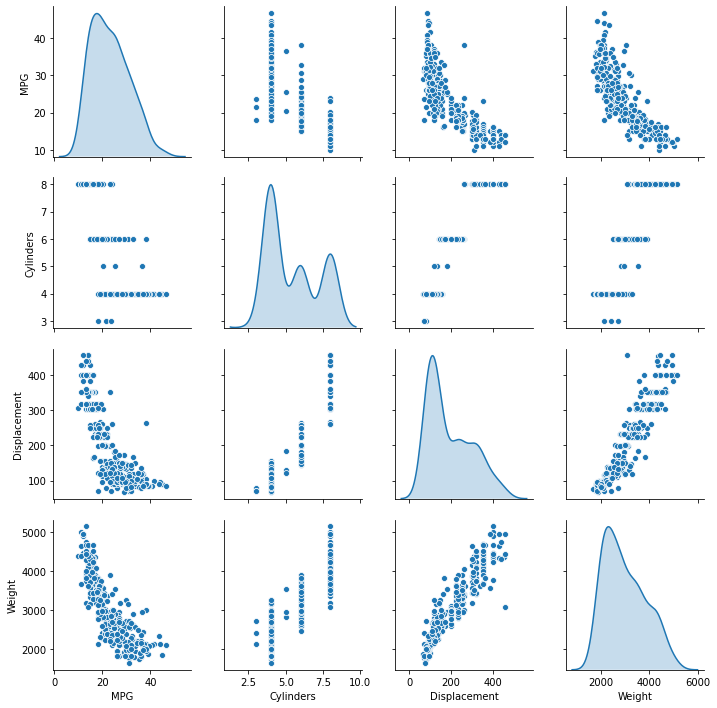

In [15]:
#Have a quick look at the joint distribution of a few pairs of columns from the training set.
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")


In [16]:
#Also look at the overall statistics:

train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

count         mean         std     min     25%     50%  \
Cylinders         314.0     5.477707    1.699788     3.0     4.0     4.0   
Displacement      314.0   195.318471  104.331589    68.0   105.5   151.0   
Weight            314.0  2990.251592  843.898596  1649.0  2256.5  2822.5   
Acceleration      314.0    15.559236    2.789230     8.0    13.8    15.5   
Model Year        314.0    75.898089    3.675642    70.0    73.0    76.0   
Origin_is_Europe  314.0     0.178344    0.383413     0.0     0.0     0.0   
Origin_is_Japan   314.0     0.197452    0.398712     0.0     0.0     0.0   
Origin_is_USA     314.0     0.624204    0.485101     0.0     0.0     1.0   

                      75%     max  
Cylinders            8.00     8.0  
Displacement       265.75   455.0  
Weight            3608.00  5140.0  
Acceleration        17.20    24.8  
Model Year          79.00    82.0  
Origin_is_Europe     0.00     1.0  
Origin_is_Japan      0.00     1.0  
Origin_is_USA        1.00     1.0

### Separate the features from the target variable(mpg)

In [17]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

In [18]:
train_dataset.head()

Cylinders  Displacement Horsepower  Weight  Acceleration  Model Year  \
146          4          90.0         75    2125          14.5          74   
282          4         140.0         88    2890          17.3          79   
69           8         350.0        160    4456          13.5          72   
378          4         105.0         63    2125          14.7          82   
331          4          97.0         67    2145          18.0          80   

     Origin_is_Europe  Origin_is_Japan  Origin_is_USA  
146                 0                0              1  
282                 0                0              1  
69                  0                0              1  
378                 0                0              1  
331                 0                1              0

### Config and train XGBoost model

In [19]:
#for tuning parameters
parameters_for_testing = {
   'colsample_bytree':[0.6,0.8],
   'gamma':[0.1,0.3],
   'min_child_weight':[1.5,6],
   'learning_rate':[0.1,0.07],
   'max_depth':[3,5],
   'n_estimators':[100],
   'reg_alpha':[1e-2,  0.75],
   'reg_lambda':[1e-2, 0.45],
   'subsample':[0.6,0.95]  
}

In [19]:
train_dataset[["Horsepower"]] = train_dataset[["Horsepower"]].apply(pd.to_numeric)

test_dataset[["Horsepower"]] = test_dataset[["Horsepower"]].apply(pd.to_numeric)
train_dataset["Horsepower"].unique()

array([ 75,  88, 160,  63,  67,  90,  60,  95, 180, 150, 155, 115, 129,
       110,  76, 165,  92, 100, 122,  74,  65, 220, 140,  78, 149,  84,
       145, 170, 200,  72, 105,  53,  86,  71, 198,  69, 215,  87,  68,
       153,  70,  81, 225,  97,  89,  85,  52, 135,  58,  96, 125,  82,
       208, 130,  46,  64, 167, 120, 190,  49, 107,  80, 133, 112, 116,
        62, 210, 103, 139,  83, 132,  91, 152, 108, 148,  94, 102,  98,
        77,  54,  48, 175, 113,  93,  61])

In [21]:
xgb_model = xgboost.XGBRegressor(learning_rate =0.1, n_estimators=100, max_depth=5,
    min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8, nthread=6, scale_pos_weight=1, seed=27,objective='reg:squarederror')

gsearch1 = GridSearchCV(estimator = xgb_model, param_grid = parameters_for_testing, n_jobs=6,iid=False, verbose=10,scoring=make_scorer(r2_score))
gsearch1.fit(train_dataset,train_labels)


Fitting 3 folds for each of 256 candidates, totalling 768 fits


You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:    2.1s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:    2.4s
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:    2.7s
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:    2.9s
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:    3.1s
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    3.2s
[Parallel(n_jobs=6)]: Done  49 tasks      | elapsed:    3.5s
[Parallel(n_jobs=6)]: Done  60 tasks      | elapsed:    3.8s
[Parallel(n_jobs=6)]: Done  73 tasks      | elapsed:    4.2s
[Parallel(n_jobs=6)]: Done  86 tasks      | elapsed:    4.6s
[Parallel(n_jobs=6)]: Done 101 tasks      | elapsed:    4.9s
[Parallel(n_jobs=6)]: Done 116 tasks      | elapsed:    5.3s
[Parallel(n_jobs=6)]: Done 133 tasks      | elapsed:    5

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.8, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=6, objective='reg:squarederror', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=None,
       subsample=0.8, verbosity=1),
       fit_params=None, iid=False, n_jobs=6,
       param_grid={'colsample_bytree': [0.6, 0.8], 'gamma': [0.1, 0.3], 'min_child_weight': [1.5, 6], 'learning_rate': [0.1, 0.07], 'max_depth': [3, 5], 'n_estimators': [100], 'reg_alpha': [0.01, 0.75], 'reg_lambda': [0.01, 0.45], 'subsample': [0.6, 0.95]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(r2_score), verbose=10)

In [22]:
# print (gsearch1.grid_scores_)
print('best params')
print (gsearch1.best_params_)
print('best score')
print (gsearch1.best_score_)



best params
{'colsample_bytree': 0.6, 'gamma': 0.1, 'learning_rate': 0.07, 'max_depth': 5, 'min_child_weight': 6, 'n_estimators': 100, 'reg_alpha': 0.01, 'reg_lambda': 0.45, 'subsample': 0.6}
best score
0.8634356143858213


### Train using the optimal HPs

In [49]:
best_xgb_model = xgboost.XGBRegressor(colsample_bytree=0.6,
                 gamma=0.1,                 
                 learning_rate=0.07,
                 max_depth=5,
                 min_child_weight=6,
                 n_estimators=100,                                                                    
                 reg_alpha=0.01,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=42,objective='reg:squarederror')
best_xgb_model.fit(train_dataset,train_labels)

Series.base is deprecated and will be removed in a future version
Series.base is deprecated and will be removed in a future version


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.6, gamma=0.1,
       importance_type='gain', learning_rate=0.07, max_delta_step=0,
       max_depth=5, min_child_weight=6, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:squarederror',
       random_state=0, reg_alpha=0.01, reg_lambda=0.45, scale_pos_weight=1,
       seed=42, silent=None, subsample=0.6, verbosity=1)

### Evaluate the model on test dataset

#### def score(X, y, sample_weight=None)
Returns the coefficient of determination R^2 of the prediction.
The coefficient R^2 is defined as (1 - u/v), where u is the residual sum of squares ((y_true - y_pred) ** 2).sum() and v is the total sum of squares ((y_true - y_true.mean()) ** 2).sum(). The best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). A constant model that always predicts the expected value of y, disregarding the input features, would get a R^2 score of 0.0.

In [50]:
best_xgb_model.score(train_dataset,train_labels)

0.9556029437329031

In [51]:
best_xgb_model.score(test_dataset,test_labels)

0.9085646714242752

In [53]:
ypred = best_xgb_model.predict(test_dataset)
mse = mean_squared_error(test_labels,ypred)
print("MSE: %.2f" % mse)

print("RMSE: %.2f" % np.sqrt(mse))



MSE: 5.97
RMSE: 2.44


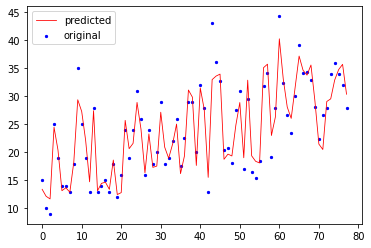

In [54]:
x_ax = range(len(test_labels))
plt.scatter(x_ax, test_labels, s=5, color="blue", label="original")
plt.plot(x_ax, ypred, lw=0.8, color="red", label="predicted")
plt.legend()
plt.show()